##  Predicting Fake are Real News 


                                By: Muluemebet Ayalew 
                                    May, 2020

In [1]:
# Important libraries
import pandas as pd
import numpy as np
import re # to use regular expression pattern 
import datetime as dt  # to parse to datetime
import string
from scipy import stats

#text processing and visualization
import nltk
from nltk.tokenize import word_tokenize, regexp_tokenize, TweetTokenizer
from collections import Counter
from nltk.corpus import stopwords          # to access stop words 
from nltk.stem import WordNetLemmatizer    # for lemmatization or steming
import spacy
from gensim.corpora.dictionary import Dictionary   # to map token , id and create corpus
from sklearn.manifold import TSNE
from wordcloud import WordCloud,STOPWORDS # to visualize frequeent words 
from gensim.models import Phrases  # to use for topic modeling 
from gensim.models.word2vec import LineSentence
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore

#for preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer  # to make word vectors 
from sklearn.model_selection import train_test_split  

# For modeling and evaluation 
from sklearn.naive_bayes import MultinomialNB  # for Naive Baye's  classification
from sklearn.linear_model import LogisticRegression
from sklearn import metrics # to evaluate model performance


# for visualization
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

In [2]:
#from  tqdm import tqdm
#from time import sleep 

##  Preprocessing  Outline:
 - tokenization 
 - lowercasing words
 - bag of words
 - lemmatization/stemming
 - removing stop words, punctuations or unwanted tokens
 - experiment with differnt approach 
- check www.snopes.com  to see unproven and false news(webscrap and get data, predicte usig the model
- 
 
 

## 1) Read the data

In [55]:
true= pd.read_csv("True.csv", parse_dates=["date"])     # the true news data
fake= pd.read_csv("Fake.csv")     # the fake news data 

In [4]:
true.head(3) # the first few rows of real dataframe

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31


In [6]:
true.shape # shape of real news before adding label

(21417, 4)

In [5]:
fake.head() # the first few rows of fake dataframe

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [7]:
fake.shape  # shape of fake news before adding label

(23481, 4)

### 1.1) Add labels(fake/true) to the  dataframs

In [56]:
# create a new column called is_fake and label as 0 for true news 
true["label"]="true"

In [57]:
# create a new column called is_fake and label as 1 for fake news 
fake["label"]= "fake"

In [58]:
# parse the date column into datetime. 
#Since it has two datetime format, we need two formats to parse.  
def parsing_datetime(string):
    for f in ("%B %d, %Y", '%d-%b-%y', "%b %d, %Y"): # format  19-Feb-18
        try:
            return dt.datetime.strptime(string, f)
        except ValueError:
            pass
        
# parse the date column of fake dataframe into datetime
fake.date= fake.date.apply(lambda x: parsing_datetime(x))

In [15]:
true.head(3)

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,true
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,true
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,true


In [20]:
fake.head(3)

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,fake


### 1.2)  Merge the real and fake dataframe

In [59]:
# Merge the fake and read dataframe
news= pd.concat([true,fake], axis=0)

In [60]:
news.sample(5).head()

,title,text,subject,date,label
14694,BREAKING: Man Rushes To Paris Police Station D...,It doesn t appear the man rushing to doors of ...,politics,2016-01-07,fake
14303,Germany's Schaeuble urges parties to compromis...,BERLIN (Reuters) - German parties must be more...,worldnews,2017-11-21,true
9635,Top U.S. official visits Vietnam to assess hum...,HANOI (Reuters) - A top U.S. envoy began a two...,politicsNews,2016-05-09,true
16704,Ankara mayor quits in Erdogan purge of local g...,ANKARA (Reuters) - The mayor of Ankara said on...,worldnews,2017-10-23,true
4998,Obama lawyers move fast to join fight against ...,WASHINGTON (Reuters) - When Johnathan Smith re...,politicsNews,2017-03-13,true


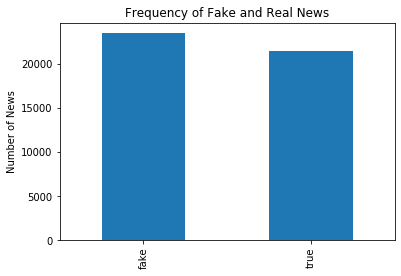

In [61]:
# bar plot the number of fake and real news
_=news.label.value_counts().plot(kind="bar", title="Frequency of Fake and Real News")
_=plt.ylabel("Number of News")


## 2)Explore the data  
Let us explore the two dataframe separately 

### Exploring real news data 

In [11]:
true.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   title    21417 non-null  object        
 1   text     21417 non-null  object        
 2   subject  21417 non-null  object        
 3   date     21417 non-null  datetime64[ns]
 4   label    21417 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 836.7+ KB


In [12]:
true.shape #the size of the real dataframe

(21417, 5)

In [12]:
true.iloc[10,1]; # sample text 

In [13]:
true.subject.unique() # unique subjects in the real news 

array(['politicsNews', 'worldnews'], dtype=object)

In [14]:
true[true.text==" "] # one real news without text

,title,text,subject,date,label
8970,Graphic: Supreme Court roundup,,politicsNews,2016-06-16,true


## Explore fake data

In [16]:
fake.info() # see the insormation after creating outcome variable(is_fake) and parsing date

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   title    23481 non-null  object        
 1   text     23481 non-null  object        
 2   subject  23481 non-null  object        
 3   date     23471 non-null  datetime64[ns]
 4   label    23481 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 917.4+ KB


In [22]:
fake.shape  # the size of the fake dataframe

(23481, 5)

In [18]:
fake[fake.date.isnull()] # fake news with invalide date 

,title,text,subject,date,label
9358,https://100percentfedup.com/served-roy-moore-v...,https://100percentfedup.com/served-roy-moore-v...,politics,NaT,fake
15507,https://100percentfedup.com/video-hillary-aske...,https://100percentfedup.com/video-hillary-aske...,politics,NaT,fake
15508,https://100percentfedup.com/12-yr-old-black-co...,https://100percentfedup.com/12-yr-old-black-co...,politics,NaT,fake
15839,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,NaT,fake
15840,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,NaT,fake
17432,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,NaT,fake
17433,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,NaT,fake
18933,Homepage,[vc_row][vc_column width= 1/1 ][td_block_trend...,left-news,NaT,fake
21869,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,NaT,fake
21870,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,NaT,fake


In [19]:
fake.iloc[9358,:] # see one of the fake news with invalid data before parsing 

title      https://100percentfedup.com/served-roy-moore-v...
text       https://100percentfedup.com/served-roy-moore-v...
subject                                             politics
date                                                     NaT
label                                                   fake
Name: 9358, dtype: object

In [25]:
fake[fake.text==" "] # 626 fake news without text

,title,text,subject,date,label
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,2017-05-10,fake
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,2017-04-26,fake
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,2017-04-06,fake
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,2017-04-02,fake
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,2017-04-01,fake
...,...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,2015-04-27,fake
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,2015-04-25,fake
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,2015-04-25,fake
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,2015-04-14,fake


### 2.1) Explore the Subject of fake and real news  

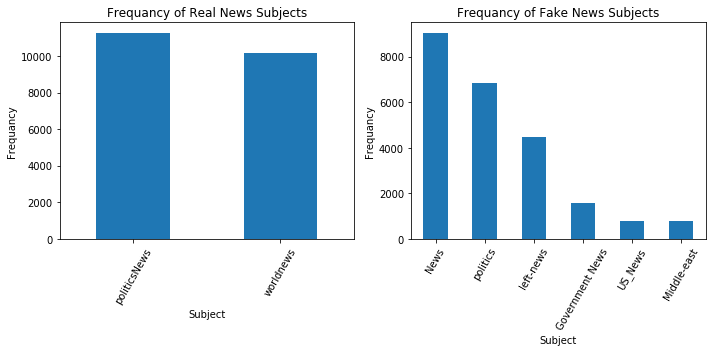

In [21]:
plt.figure(figsize=(10,5))

plt.subplot(121)
_=true.subject.value_counts().plot.bar()
_=plt.ylabel("Frequancy")
_=plt.title("Frequancy of Real News Subjects")
_=plt.xlabel("Subject")
_=plt.xticks(rotation=60)

plt.subplot(122)
_=fake.subject.value_counts().plot.bar()
_=plt.xlabel("Subject")
_=plt.ylabel("Frequancy")
_=plt.title("Frequancy of Fake News Subjects")
_=plt.xticks(rotation=60)

plt.tight_layout()
plt.show()


### 2.2 Explore date 
The year span for the fake news is from 2015 to 2018 whereas the real data has news for 2016 and 2017. The monthes september october, november and december have the most number of news from the real dataset.  

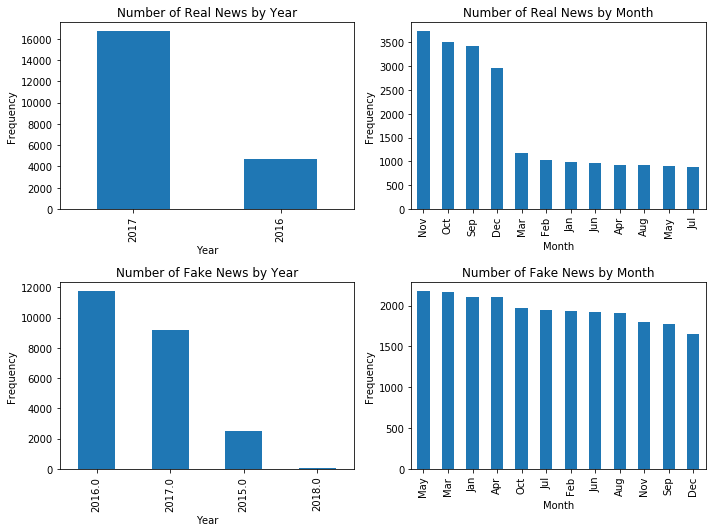

In [22]:
#Exploring Year 

plt.figure(figsize=(10,7.5)) # set figure size

# Number Real news by year 
plt.subplot(221)
true.date.dt.year.value_counts().plot(kind="bar", title="Number of Real News by Year")
plt.xlabel("Year")
plt.ylabel("Frequency")

# Number Real news by month 
plt.subplot(222)
true.date.dt.strftime("%b").value_counts().plot(kind="bar", title="Number of Real News by Month")
plt.xlabel("Month")
plt.ylabel("Frequency")


# Number of fake news by year 
plt.subplot(223)
fake.date.dt.year.value_counts().plot(kind="bar", title="Number of Fake News by Year")
plt.xlabel("Year")
plt.ylabel("Frequency")

#Number of fake news by month
plt.subplot(224)
fake.date.dt.strftime("%b").value_counts().plot(kind="bar", title="Number of Fake News by Month")
plt.xlabel("Month")
plt.ylabel("Frequency")
plt.tight_layout()

plt.show()

### 2.3) Explore the news title and text 
The function extract_pattern() is used to count the number of a regrular expression pattern appered in a news. For this section it is used to extract for number of emoji, url and  tags.

In [26]:
def extract_pattern(data, pattern):
    """retruns the number of patters appeared in each news"""
    extract= re.findall(pattern, data)
    return len(extract)

### Number of  Emoji in fake and real news

#### Emoji in title 

The title of real news have no emoji symbols at all where as there is one title with emoji for fake news. 

In [27]:
#Emoji symbols
emoji = "[\U0001F300-\U0001F5FF\U0001F600-\U0001F64F\U0001F680-\U0001F6FF\u2600-\u26FF\u2700-\u27BF\U000024C2-\U0001F251]+"


In [28]:
print(emoji)

[🌀-🗿😀-🙏🚀-🛿☀-⛿✀-➿Ⓜ-🉑]+


In [29]:
# maximum number of emoji available in a title of fake news 
fake["num_emoji_ttl"]= fake.title.apply(extract_pattern, pattern=emoji)

fake.title[fake.num_emoji_ttl.idxmax()] # Extract the title with max number of emoji on it 

'SHOCKING MUST WATCH VIDEO: Muslim Leaders Just Openly Declared War On The American Population\ufeff'

In [30]:
# maximum number of emoji available in the title of real news 
true["num_emoji_ttl"]= true.title.apply(extract_pattern, pattern=emoji)

true.num_emoji_ttl.max() # Extract the data title with max number of emoji on it

0

### Emoji in text
There is no emoji symbol in any of the fake text whereas there are three kind of emoji symbols detected from the text of three true news. 

In [31]:
# maximum number of emoji available in the text of fake news 
fake["num_emoji_txt"]= fake.text.apply(extract_pattern, pattern=emoji)

fake.num_emoji_txt.max() # Extract the data title with max number of emoji on it 

0

In [32]:
# maximum number of emoji available in the text of real news 
true["num_emoji_txt"]= true.text.apply(extract_pattern, pattern=emoji)

true.num_emoji_txt.max() # Extract the data title with max number of emoji on it 

3

In [33]:
true[true.num_emoji_txt>0] # There are three news with emoji symbol in real news 

,title,text,subject,date,label,num_emoji_ttl,num_emoji_txt
1179,"Trump on Twitter (Oct 17) - Tom Marino, Greek ...",The following statements were posted to the ve...,politicsNews,2017-10-17,true,0,1
2023,Factbox: Trump on Twitter (Aug 24) - Debt ceil...,The following statements were posted to the ve...,politicsNews,2017-08-24,true,0,3
3673,"Traveling abroad, Trump struggles to escape cr...",RIYADH (Reuters) - President Donald Trump was ...,politicsNews,2017-05-20,true,0,1


In [34]:
# the type of emoji symbols  found in the text of real news
text_emoji=true.text.apply(lambda x: re.findall(emoji,x))
for idx in [1179, 2023, 3673]:
    print(text_emoji.loc[idx])

['➡️']
['☑️', '☑️', '☑️']
['ツ']


### Number of url links in fake and real news

#### Number of url links in title
There are 9 fake news title with url links but none of the title on real news have url link 

In [35]:
# url pattern
url= re.compile("https?://\S+|www\.\S+")

In [36]:
fake["num_url_ttl"]= fake.title.apply(extract_pattern, pattern=url)

len(fake[fake.num_url_ttl>0]) # number of news title with url link 

9

In [37]:
fake[fake.num_url_ttl>0];

In [38]:
true["num_url_ttl"]= true.title.apply(extract_pattern, pattern=url)

len(true[true.num_url_ttl>0])  # number of news title with url link 

0

#### Number of url links in text

In [39]:
fake["num_url_txt"]= fake.text.apply(extract_pattern, pattern=url)

len(fake[fake.num_url_txt>0]) # number of news title with url link 

3356

In [40]:
true["num_url_txt"]= true.text.apply(extract_pattern, pattern=url)

len(true[true.num_url_txt>0]) # number of news title with url link 

41

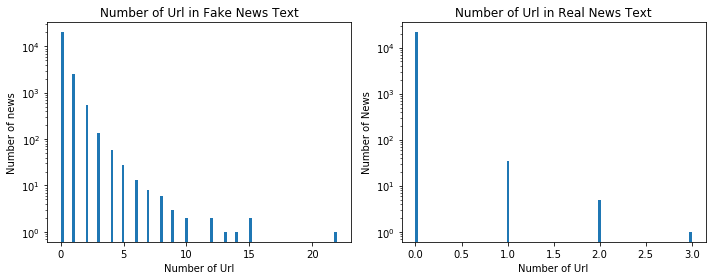

In [41]:
plt.figure(figsize=(10,4))

# plot number of fake news url 
plt.subplot(121)
fake.num_url_txt.plot(kind="hist",bins=100, title="Number of Url in Fake News Text")
plt.yscale("log")
plt.xlabel("Number of Url")
plt.ylabel("Number of news")

# plot number of true news url
plt.subplot(122)
true.num_url_txt.plot(kind="hist",bins=100, title="Number of Url in Real News Text")
plt.yscale("log")
plt.xlabel("Number of Url")
plt.ylabel("Number of News")
plt.tight_layout()
plt.show()

### Tag , mension and & smbols 

#### Tag , mension and & smbols in title 

In [42]:
#pattern for tag(#), mension(@) and & symbols
tag_mensn= "[#@&]+"

In [43]:
fake["num_tag_ttl"]= fake.title.apply(extract_pattern, pattern=tag_mensn)

len(fake[fake.num_tag_ttl>0]) 

862

In [44]:
true["num_tag_ttl"]= true.title.apply(extract_pattern, pattern=tag_mensn)

len(true[true.num_tag_ttl>0]) 

25

#### Tag , mension and & smbols int text

In [45]:
fake["num_tag_txt"]= fake.text.apply(extract_pattern, pattern=tag_mensn)

len(fake[fake.num_tag_txt>0]) 

7682

In [46]:
fake.num_tag_txt.max()

934

In [47]:
fake.text[2902];

In [48]:
true["num_tag_txt"]= true.text.apply(extract_pattern, pattern=tag_mensn)

len(true[true.num_tag_txt>0]) 

1171

Text(0.5, 1.0, 'Frequency of tags in real news title')

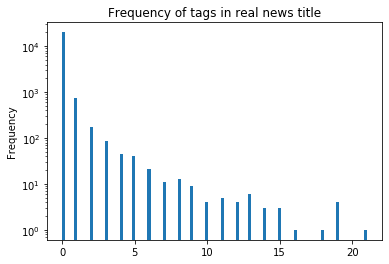

In [50]:
true.num_tag_txt.plot(kind="hist", bins=100)
plt.yscale("log")
plt.title("Frequency of tags in real news title")

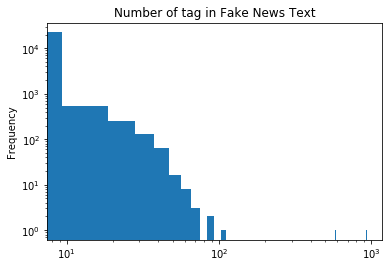

In [51]:
fake.num_tag_txt.plot(kind="hist",bins=100, title="Number of tag in Fake News Text")
plt.yscale("log")
plt.xscale("log")

####  html pattern

In [52]:
html= r'<.*?>'

In [53]:
# html in fake  news title
fake["num_html_ttl"]= fake.title.apply(extract_pattern, pattern=html)
print("Number of fake news title with html tag: ", len(fake[fake.num_html_ttl>0]))

# html in real news  title
true["num_html_ttl"]= true.title.apply(extract_pattern, pattern=html)
print("Number of real news title with html tag: ",len(true[true.num_html_ttl>0]))

Number of fake news title with html tag:  0
Number of real news title with html tag:  0


In [54]:
# html in fake news text
fake["num_html_txt"]= fake.text.apply(extract_pattern, pattern=html)
print("Number of fake news text with html tag: ", len(fake[fake.num_html_txt>0]))


true["num_html_txt"]= true.text.apply(extract_pattern, pattern=html)
print("Number of real news text with html tag: ", len(true[true.num_html_txt>0])) 

Number of fake news text with html tag:  79
Number of real news text with html tag:  8


###  summary of title and text sympols and special characters 
                title              ||           text 
         emoji | url | punctuation || emoji | url | punctuation|
         --------------------------------------------------------
    fake |
    true |

## 3)  Data Cleaning preprocessing:
removing html tags, removing, url links, removing, specal characters, remove punctuations, emoji, punctuation, stopwords 

CountVectorizer handles stop words and special characters and punctuation.

    - apply the remove_pattern function and use countvectore(it can handle special caracture punctuation and stope words) to get features and make prediction 
    - also check to limit mx and min df for word count to be consideded as feature
    -compair the result.
    
  title 15392, fake text 83,709, after cleaning with some paterns 78582, 73653 after removing words contining numbers,
#the two data set together, the text has 122,002 features withoucleaning 
    

###  Function to remove patterns(emoji, url, html , special characteres.....)

In [62]:
#patterns= [emoji, url, html]
def remove_pattern(text, patterns):
    """The function remove_pattern returns the new string with a set of patterns removed.
       Parameters:
       ------------
       data: the text from which the pattern will be removed
       patterns: is the set of patterns(iterable) we are intereted to remove from the text
       """
           
    for pattern in patterns:
        new= re.sub(pattern, "", text)
        text= new 
    return new

In [70]:
# patterns to be extracted and to be removed from the data 
emoji = "[\U0001F300-\U0001F5FF\U0001F600-\U0001F64F\U0001F680-\U0001F6FF\u2600-\u26FF\u2700-\u27BF\U000024C2-\U0001F251]+"
url= re.compile("https?://\S+|www\.\S+")
html= r'<.*?>'
#num= r"\d+"

num_with_text= r"\S*\d+\S*"

# collect the patterns 
patterns=[emoji, url, html, num_with_text]

### 3.1)Look at world cloud after cleaning

In [71]:
# merge all the text in title column for fake and real dataset separately and cleanup 
fake_title= remove_pattern(" ".join(fake.title), patterns)
true_title= remove_pattern(" ".join(true.title),patterns)

# merge all the text in text column for fake and real dataset separately and cleanup 
fake_text= remove_pattern(" ".join(fake.text), patterns)
true_text= remove_pattern(" ".join(true.text),patterns)

In [72]:
def plot_wordcloud(text, title_name):
    """The function displays the word could  of the text with the given title name """
    
    if isinstance(text, str) and isinstance(title_name, str): # to make sure the parameters have the correct data type
        
        plt.figure(figsize = (15,15))
        wc = WordCloud(max_words = 100 , width = 1600 , height = 800, stopwords=stopwords.words("english")).generate(text)
        plt.imshow(wc , interpolation = 'bilinear')
        _=plt.title(title_name, fontdict= {"fontsize": 20})
        _=plt.axis("off")
    
    else:
        print("please provide the correct parameter type")

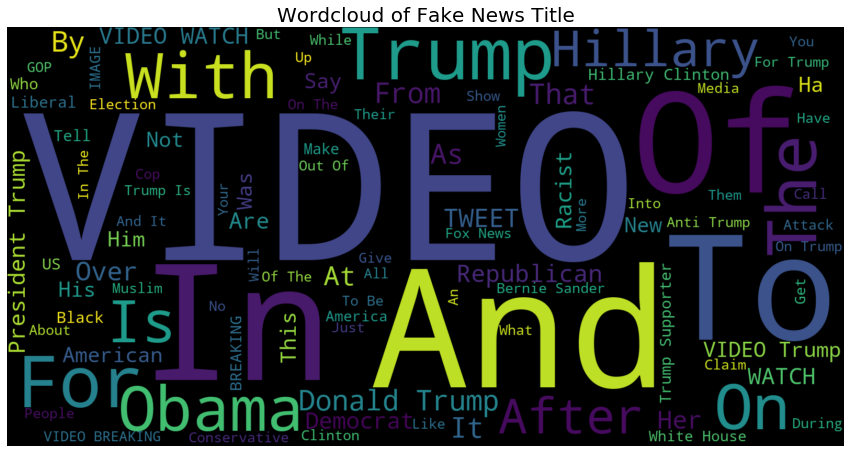

In [73]:
plot_wordcloud(fake_title, "Wordcloud of Fake News Title")

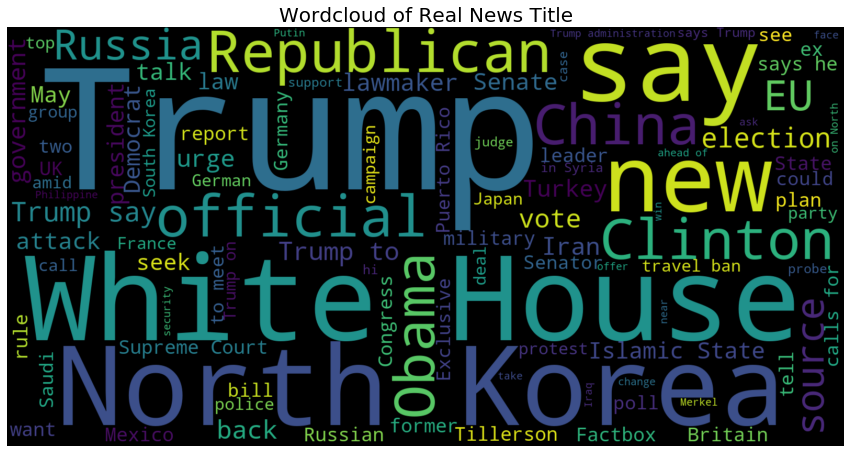

In [74]:
plot_wordcloud(true_title, "Wordcloud of Real News Title")

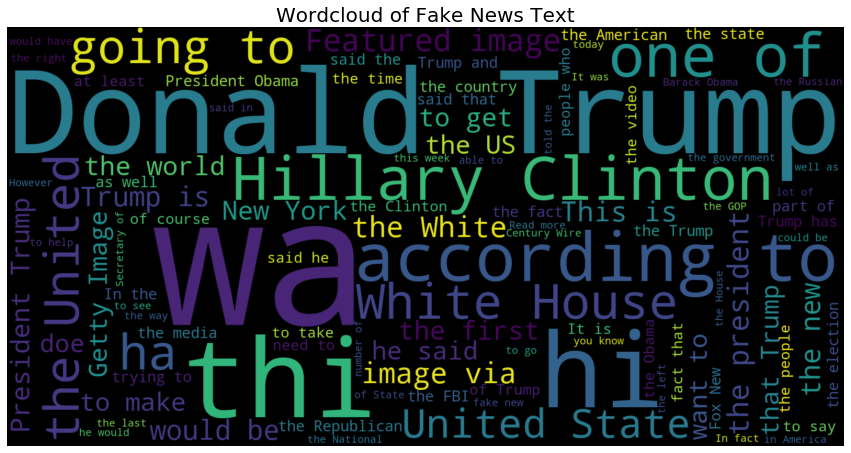

In [75]:
plot_wordcloud(fake_text, "Wordcloud of Fake News Text")

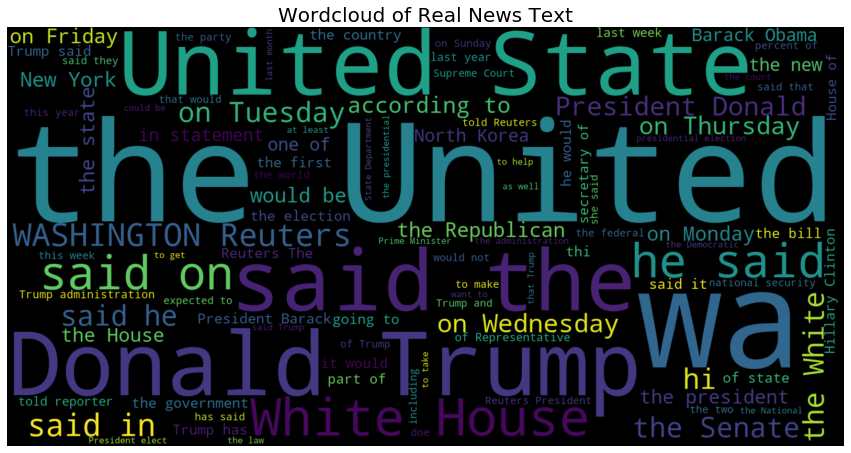

In [76]:
plot_wordcloud(true_text, "Wordcloud of Real News Text")

In [77]:
# use count vectorizer
cc=CountVectorizer(min_df=3)
dd=cc.fit_transform (news.text)#fake.text.apply(lambda x: re.findall(ext,"" x))[7715])
len(cc.get_feature_names())# now punctuations are droped and the data is cleaned!

53071

### cases for my reference --------to be deleted 

In [16]:
s= "there are three. One is: https://100percentfedup.com/served-roy-moore-\ , two is :-  \
www.hello.com, three is ; http://datascienceandme.com/ and fakeurl http//:myweb.com and more url=\
        https://www.google.com/ tags such as <html>👍 and smile😊  #hash and mension @ also punc44tuation! marks ?"

In [159]:
# use count vectorizer
cc=CountVectorizer()
dd=cc.fit_transform ([fn])
#cc.get_feature_names()# now punctuations are droped and the data is cleaned!

In [81]:
# Percentage of words that appear in less than 5 documents.
yint=stats.percentileofscore(xt,1000) 
print(yint)

99.94713889255979


In [72]:
np.percentile(xt, 70)

7.0

In [74]:
np.quantile(xt,0.999)  


702.8670000000002

### 3.2)  Clean fake and real news dataframe separately

The function remove_pattern() is defined under section 3. Please refer back to see how it was defined.

In [78]:
#clean the title of fake and real news using regular expression patterns
fake_ttl_clean= fake.title.apply(remove_pattern, patterns= patterns)
true_ttl_clean= true.title.apply(remove_pattern, patterns= patterns)

In [79]:
# clean the text of fake and real news using regular expression patterns
fake_txt_clean= fake.text.apply(remove_pattern, patterns= patterns)
true_txt_clean= true.text.apply(remove_pattern, patterns= patterns)


### 3.2) Create count vector for the cleaned data

In [81]:
def count_vect(data, min_df):
    """returns the CountVectorizer object and the fitted count vector of the data with 
    the given number of minimum document frequancy.
    parameter:
    -------
        data : collection of text document
        min_df : the minimum document frequency When building the vocabulary """
    
    cv= CountVectorizer(stop_words="english", min_df=min_df )
    trans= cv.fit_transform(data)
    return cv, trans

In [83]:
# count vector for title of the news 
fake_wc_ttl, fake_cv_title= count_vect(fake_ttl_clean,1)
true_wc_ttl, true_cv_title= count_vect(true_ttl_clean, 1)

In [84]:
# feature names for fake and real news title
fake_feature_ttl= fake_wc_ttl.get_feature_names()
true_feature_ttl= true_wc_ttl.get_feature_names()

In [85]:
fake_cv_title.sum(0) #value

matrix([[ 2,  3,  9, ..., 17,  4,  2]], dtype=int64)

In [86]:
df=pd.DataFrame(fake_cv_title.toarray(), columns= fake_feature_ttl)

In [89]:
df.head(2)

,aaron,aarp,abandon,abandoned,abandoning,abandons,abbott,abc,abdication,abdo,...,zombiehillary,zone,zones,zoning,zoo,zoolander,zucker,zuckerberg,état,žižek
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


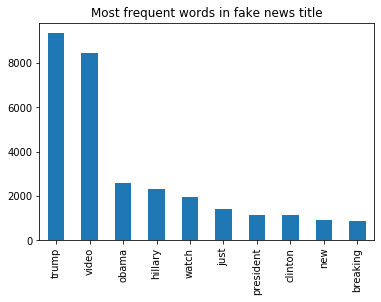

In [90]:
df.sum(0).sort_values(ascending=False)[:10].plot(kind='bar') # frequency of words 
_=plt.title("Most frequent words in fake news title")

## 3.3) Distribution of number of words appeared in a news and frequancy of words in the datasets


- Note: sum(0) gives the numer of times a word appeared in the whole news article  not just the number of news articles containing a word. A word may appered more then one times in a news and sum up. 

In [91]:
def cum_dist(count_vector, axis): 
    """Displays the emprical cumulative distribution function given the count vector of the text data and 
    the axis on which it is aggregated   """
    
 
    if axis==1: # sum column wise to get the number of words in a news 
        num_words=count_vector.sum(1) # sum number of words in a news 
        x=np.sort(num_words.transpose()) # sort in ascending order
        length=num_words.shape[0] # Number of news 
        xt=x.transpose()
        y= np.arange(1,length+1)/length 
        xlabel="Number of words "
        title= "Cumulative distribution of news frequency "
               
    elif axis==0 :    #sum row wise to get the number of documents a word appeared            
        
        freq= count_vector.sum(0) #number of times a word apeared in the data 
        length= freq.shape[1]  # number of unique words 
        x= np.sort(freq)
        xt=x.transpose()
        y= np.arange(1,length+1)/length
        xlabel="Frequency of words"
        title= "Cumulative distribution of word frequency "
    else:
        print("Invalid axis entry!" )
    _=plt.plot(xt,y)
    _=plt.xlabel(xlabel)
    _=plt.ylabel("PMF")
    _=plt.title(title)  
    _=plt.xscale("log")
 

In [92]:
#fake_wc_ttl.vocabulary_ ;# dictionary of key= word and value is the indice

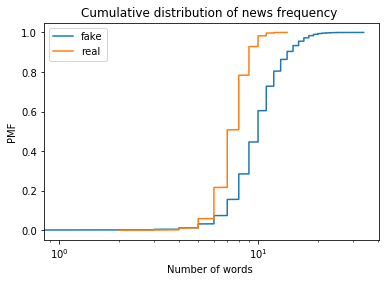

In [93]:
# number of words in a news title 
cum_dist(fake_cv_title, axis=1)
cum_dist(true_cv_title, axis=1)
plt.legend(["fake", "real"])
plt.show()

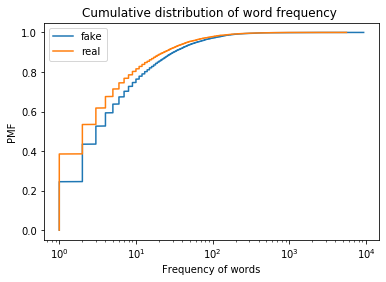

In [94]:
#number of times a word apeared in different news titles  
cum_dist(fake_cv_title, axis=0)
cum_dist(true_cv_title, axis=0)
_=plt.legend(["fake", "real"])

In [95]:
# count vector for text of the news 
fake_wc_txt, fake_cv_text= count_vect(fake_txt_clean,1)
true_wc_txt, true_cv_text= count_vect(true_txt_clean, 1) 

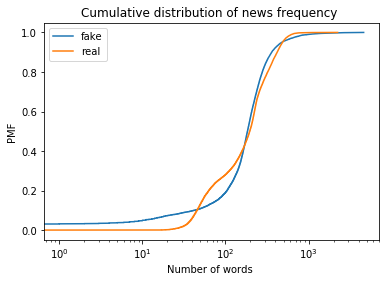

In [96]:
# number of words in a news text 
cum_dist(fake_cv_text,axis=1)
cum_dist(true_cv_text, axis=1)
plt.legend(["fake", "real"])
plt.show()

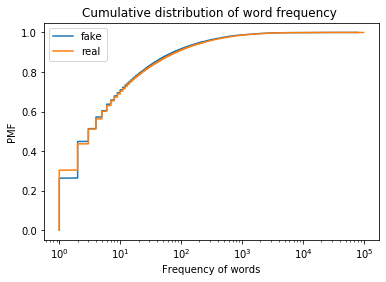

In [97]:
# number of times a word appeared in data 
cum_dist(fake_cv_text,axis=0)
cum_dist(true_cv_text, axis=0)
_=plt.legend(["fake", "real"])

In [98]:
#Shape of the count vector of real news text
true_cv_text.toarray().shape

(21417, 62933)

In [100]:
# shape  of the count vector of fake text
fake_cv_text.toarray().shape

(23481, 78935)

In [101]:
cv_real=CountVectorizer(stop_words="english")
tt= cv_real.fit_transform(true.text)
feature_tr=cv_real.get_feature_names()

In [103]:
cv_fake=CountVectorizer(stop_words="english")
tt= cv_fake.fit_transform(fake.text)
feature_fk=cv_fake.get_feature_names()

In [105]:
set(feature_tr)-set(feature_fk) # words only available in true news 

{'reichel',
 'sato',
 'bonkle',
 'cero',
 'brazzaville',
 'outspends',
 '2fihfyc',
 'pag',
 'wasonga',
 'backslide',
 'stargardter',
 'buana',
 'wollaston',
 'juggle',
 'iwakuni',
 'gunawardena',
 'gantz',
 'caso',
 'kawakami',
 'usuallyinvited',
 'clauss',
 'uluru',
 'aung',
 'rubens',
 'minoru',
 'komi',
 'caggins',
 'shalaw',
 'phongthep',
 'tabish',
 'hashtagify',
 'practicalities',
 'antidze',
 '02197',
 'uob',
 'prak',
 'mdlz',
 'bicyclist',
 '9179',
 'bolshoi',
 'mullarah',
 'masipa',
 'rajnandini',
 'wecht',
 '10037',
 'chissanda',
 'bunga',
 'doskozil',
 'gnassingb',
 'tine',
 'wayan',
 'jefe',
 'perosino',
 'pilita',
 'kator',
 'piranha',
 'zackford',
 '8461',
 'edre',
 'inarguable',
 '746',
 'shireman',
 'cortland',
 'soyoil',
 'repetto',
 'tapestry',
 '1p1h0nd',
 'poso',
 'stagflation',
 'kilby',
 'vannak',
 'croat',
 'shafi',
 'qahraman',
 'nostrovia',
 'grabar',
 'madhesi',
 'wetangula',
 'atu',
 'spratlys',
 'eurobond',
 'felsman',
 'goateed',
 'josie',
 'lesjean',
 'esf

#### Lematize the words  - --- to be  continued 

In [ ]:
lemma = nltk.WordNetLemmatizer()
lemma_roots = [lemma.lemmatize(each) for each in text]
print(lemma_roots)

**Spacy** 

- tokenization
- lematization 
- Use gensim for preprocessing( use Dictionary, and use spacy = 1hr, ) 
- try  n-gram and see model performance, use tfidf  and see model performance, try also lematized words and see the result. a merge title and text and see model performance,




## 4) Test statistics: Is the length of the text determine the type of news? 
H0= the title of fake and real news have the same word length 
H1: Real news have shorter word length 

#### Step1: Formulate the null and alternative hypohesis :

The null hypothesis: The title of fake and real news have the same word length. 
Althernative hypothesis : Real news title have shorter word length.

#### Step 2 : Set the significance level
The significance level, 𝛼 , is set as 0.05(5%) .

#### Step 3: Compute the mean of a concatenated title length
To perform this hypothesis test, we need to shift the two data sets so that they will have the same mean and then use bootstrap sampling to compute the difference of means.

In [106]:
# Compute mean of combined data set: combined_mean
news_clean_title = news.title.apply(remove_pattern, patterns= patterns)

In [107]:
mean_len_ttl= count_vect(news_clean_title,1)[1].sum(1).mean()
print(mean_len_ttl)

8.957058220856164


#### Step 4: Shift the two groups data to get the same mean


In [108]:
# Shift the samples
fake_shifted = fake_cv_title.sum(1) -np.mean(fake_cv_title.sum(1))+ mean_len_ttl
true_shifted = true_cv_title.sum(1) -np.mean(true_cv_title.sum(1))+ mean_len_ttl

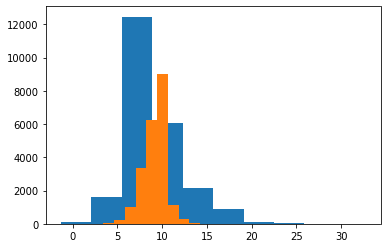

In [109]:
_=plt.hist(fake_shifted)
_=plt.hist(true_shifted)

#### Step 5: Get bootstrap replicates of shifted data sets
Take 10,000 bootstrap replicates,bootstrap replicates are the statistics computed from resampled array(in this case mean), of the mean length of each type of news title.

In [112]:
def bs_repl(data, func, size):
    """ boostrap replicates of the statistics defined by 'func' from bootstraped samples of size equal to 'size'"""
    bs_replicate=np.empty(size)
    for i in range(size):
        bs_sample= np.random.choice(data, size=data.shape[0]) #  the mean of bootstraped samples
        bs_replicate[i]=func(bs_sample)
    return bs_replicate

In [114]:
#bs_replicates_fake = bs_repl(fake_shifted, np.mean,10000)
#bs_replicates_true = bs_repl(true_shifted, np.mean,10000)

# Compute replicates of difference of means: bs_diff_replicates
#bs_diff_replicates = bs_replicates_fake - bs_replicates_true

#### Step 6: Compute  p-value 

In [ ]:

# Compute the p-value
p = np.sum(bs_diff_replicates >= (np.mean(fake_cv_title.sum(1))-np.mean(true_cv_title.sum(1)) / len(bs_diff_replicates)

# Print p-value
print('p =', p)

### which words/features are strong predictors  ---- to be deleted 

In [ ]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0] # 
ind = np.argsort(probs)# return the indices that would sort an array

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

In [ ]:
x = np.eye(fake.shape[1])
probs = clf.predict_log_proba(x)[:, 0] # 
ind = np.argsort(probs)# return the indices that would sort an array

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

## 5)  Split the data into training and test data

In [115]:
X= news.drop("label", axis=1) # potential predictors 
y= news["label"]              # outcome variable

# Split the data into training and test data
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.3, random_state=10)

In [118]:
print("X-train", X_train.shape)
print("y-train", y_train.shape)

print("X-test", X_test.shape)
print("y-test", y_test.shape)

X-train (31428, 4)
y-train (31428,)
X-test (13470, 4)
y-test (13470,)


## 6) Making Classification Models

-make separate functions to make bag of words and to fit the model. 

In [125]:
### 

def get_vector(X_train, X_test, column_name, vectorizer):
    """Returns the vector of training and test data from the given column using the specified vectorizor.
    
    parameter:
    ----------------
        column_name: the name of the column of the datafame from which we want to get the vectors
        vectorizore: could be countVectorizer or TfidfVectorizer to vectorize the text.
        X_train/X_test: training and test data, respectively
          """
    
    # extract the data for the given column
    X_trn= X_train[column_name]
    X_tst= X_test[column_name]
    
    #Instantiate CountVectorizer object 
    count_v= vectorizer(stop_words="english", lowercase=True)

    # Transform the training data using only the given column values
    count_train = count_v.fit_transform(X_trn)

    # Transform the test data using only the given column values
    count_test = count_v.transform(X_tst)
    
    return count_train, count_test


def model_vect(X_train, X_test,column_name,vectorizer, model_name):   # X= news["text"]  # use text column as predictor 
    """The function model_vect returns the performance of a classification model using 
    a specified vectorizer from the given column name(column_name) of trianing and test data sets
    
    parameter :
        column_name: is the predictor column name as given in the original dataframe. It is string.
        model_name: instance of classiication machine learning method used
        vectorizer: the name of the vectorizer used (CountVectorizer/TfidfVectorizer)
        X_train/X_test: training and test data, respectively                        
   """
  
    count_train, count_test= get_vector(X_train, X_test, column_name, vectorizer) 
            
    # fit the trianining data with a machine learning method
    model=model_name.fit(count_train,y_train)
        
    # predict for test data 
    pred= model.predict(count_test)
    
    # return the classification report: cm
    #cm = metrics.classification_report(y_test, pred, labels=["true","fake"])
    cm = metrics.confusion_matrix(y_test, pred, labels=["true","fake"]) # confusion matrix
    return(cm)

###  6.1) Classification based on the title of the news using count vector


In [126]:
print("\033[1m Naive Baye's Classifier Performance \033[0m\n",\
      model_vect(X_train, X_test, "title", CountVectorizer, MultinomialNB()))
print("\033[1m Logistic Regression Classifier Performance \033[0m\n", \
      model_vect(X_train, X_test,"title",CountVectorizer, LogisticRegression(C=0.8)))


 Naive Baye's Classifier Performance 
 [[5906  508]
 [ 334 6722]]
 Logistic Regression Classifier Performance 
 [[6144  270]
 [ 424 6632]]


### 6.2) Classification based on the title of the news usin Tfidf

In [127]:
print("\033[1m Naive Baye's Classifier Performance \033[0m\n",\
      model_vect(X_train, X_test,"title",TfidfVectorizer, MultinomialNB()))
print("\033[1m Logistic Regression Classifier Performance \033[0m\n",\
      model_vect(X_train, X_test,"title",TfidfVectorizer, LogisticRegression(C=0.5)))


 Naive Baye's Classifier Performance 
 [[5848  566]
 [ 325 6731]]
 Logistic Regression Classifier Performance 
 [[6075  339]
 [ 496 6560]]


### 6.3)Classification based on the text of the news using count vector 

In [129]:
print("\033[1m Naive Baye's Classifier Performance \033[0m\n",\
      model_vect(X_train, X_test, "text", CountVectorizer, MultinomialNB()))
print("\033[1m Logistic Regression Classifier Performance \033[0m\n", \
      model_vect(X_train, X_test,"text",CountVectorizer, LogisticRegression(C=0.8)))


 Naive Baye's Classifier Performance 
 [[6070  344]
 [ 343 6713]]
 Logistic Regression Classifier Performance 
 [[6400   14]
 [  24 7032]]


C:\Users\mgaya\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### 6.4)Classification based on the text of the news using tfidf 

In [131]:
print("\033[1m Naive Baye's Classifier Performance \033[0m\n",\
      model_vect(X_train, X_test,"text",TfidfVectorizer, MultinomialNB()))
print("\033[1m Logistic Regression Classifier Performance \033[0m\n",\
      model_vect(X_train, X_test,"text",TfidfVectorizer, LogisticRegression(C=3)))

 Naive Baye's Classifier Performance 
 [[5951  463]
 [ 411 6645]]
 Logistic Regression Classifier Performance 
 [[6358   56]
 [  69 6987]]


In [137]:
accuracy = (6987 + 6358)/(6987 + 6358 +56+69)
print(accuracy)    #  0.9907201187824796

0.9907201187824796


In [133]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

### 6.4) Parameter tunning for logistic regression 

In [134]:
def make_pipeline(vectorizer, model):
     
    steps= [("vectorization", vectorizer), ("model", model) ]
    pipeline= Pipeline(steps, verbose=True)
    return pipeline

def grid_search(pipline, param_grid):
    # Instantiate the GridSearchCV object
    grid_cv = GridSearchCV(pipline, param_grid ,cv=5)
    return grid_cv

In [136]:
logreg = LogisticRegression()
c_space = np.logspace(-4, 6, 10) # values of parameter, C
param_grid = {"C": c_space}

#get count  vector for training and test data  from the news text
count_train, count_test= get_vector(X_train, X_test,"text", CountVectorizer)

grid_cv = GridSearchCV(logreg, param_grid ,cv=5)
grid_cv.fit(count_train, y_train)

# Print the optimal parameters and best score
print("Tuned Logistic Regression Parameter: {}".format(grid_cv.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(grid_cv.best_score_))

C:\Users\mgaya\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\mgaya\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

C:\Users\mgaya\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\mgaya\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

Tuned Logistic Regression Parameter: {'C': 35.93813663804626}
Tuned Logistic Regression Accuracy: 0.9948771512049228


C:\Users\mgaya\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [138]:
# pipeline to make count vector and then logistic model
logreg_pip= make_pipeline(CountVectorizer(), LogisticRegression()) 
logreg_cv=grid_search(logreg_pip, param_grid )

### plan for the models
- replace empty text by something
- use text embeding(word2vec)
- use n-grams 